## Dimensionality Reduction

In [2]:
import pandas as pd;
import numpy as np;
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import umap
import matplotlib.pyplot as plt

c:\Users\Muqri Qawiem\Downloads\data-mining-warehousing-wages-analysis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
feature_matrix = pd.read_csv("feature_engineered_survey.csv", low_memory=False)
feature_matrix

,profile_id,yearly_compensation,ml_spending,used_tpu,Total_Experience,demographics.COUNT(profileTable),demographics.MEAN(profileTable.yearly_compensation),demographics.SUM(profileTable.yearly_compensation),company.COUNT(profileTable),company.MEAN(profileTable.yearly_compensation),...,primary_tool_Cloud-based data software & APIs,primary_tool_Local development environments,primary_tool_Other,recommended_language_Other,recommended_language_Python,recommended_language_R,recommended_language_SQL,income_category_B40,income_category_M40,income_category_T20
0,0,11,2,1,4,638,11.463950,7314.0,1048,10.997137,...,False,True,False,False,True,False,False,False,False,True
1,1,15,0,0,0,902,8.657428,7809.0,352,6.738636,...,False,True,False,False,True,False,False,True,False,False
2,2,2,3,1,6,902,8.657428,7809.0,101,10.534653,...,False,True,False,False,True,False,False,False,True,False
3,3,22,0,1,8,159,7.880503,1253.0,1048,10.997137,...,False,True,False,False,True,False,False,False,False,True
4,4,0,3,0,8,158,11.063291,1748.0,986,8.873225,...,False,True,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,7794,1,3,0,6,1706,10.340563,17641.0,986,8.873225,...,False,True,False,False,True,False,False,True,False,False
7795,7795,17,3,0,4,159,7.880503,1253.0,321,10.367601,...,False,True,False,False,True,False,False,False,True,False
7796,7796,8,3,1,4,1706,10.340563,17641.0,197,10.532995,...,False,True,False,False,True,False,False,False,True,False
7797,7797,19,2,0,6,1706,10.340563,17641.0,231,10.917749,...,False,True,False,False,True,False,False,False,False,True


### Manual Reduction
Drop B40, M40, T20 income category as this standard is only in Malaysia only

In [4]:
feature_matrix.drop(columns=['income_category_B40', 'income_category_M40', 'income_category_T20'], inplace=True)

Drop id

In [5]:
feature_matrix.drop(columns=['profile_id'], inplace=True)

### Standardize Data

In [6]:
# Function to dynamically map ordinal categories
def dynamic_ordinal_mapping(df, columns):
    """
    Dynamically maps ordinal values for specified columns in a dataframe.
    Automatically assigns integer values based on the order of unique categories.

    Args:
        df (pd.DataFrame): Input dataframe.
        columns (list): List of columns to apply ordinal mapping.

    Returns:
        pd.DataFrame: Dataframe with ordinal-encoded columns.
        dict: Dictionary with column names as keys and their value-to-ordinal mappings as values.
    """
    column_mappings = {}  # To store the mappings for each column

    for col in columns:
        # Extract unique categories and sort them logically
        unique_categories = sorted(df[col].unique())
        ordinal_mapping = {category: i for i, category in enumerate(unique_categories)}
        
        # Store the mapping for the current column
        column_mappings[col] = ordinal_mapping

        # Replace categories with ordinal values
        df[col] = df[col].map(ordinal_mapping)
        
    return column_mappings, df

# Apply to ordinal columns in your dataset
ordinal_columns = [
    'company_size'
]

ordinal_map, feature_matrix = dynamic_ordinal_mapping(feature_matrix, ordinal_columns)
ordinal_map

{'company_size': {'Enterprise': 0,
  'Large': 1,
  'Medium': 2,
  'Mid-Large': 3,
  'Small': 4}}

In [7]:
# Standardize Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

### PCA

In [8]:
# Apply PCA with automatic component selection (MLE)
pca = PCA(n_components='mle')
principal_components = pca.fit_transform(scaled_features)

# Assign dynamic column names based on the number of components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96
0,0.417714,2.408146,-1.815437,-0.902849,-1.401302,-1.735015,2.195338,0.779346,0.384287,1.094877,...,0.053978,-0.806097,0.698346,-1.094532,-0.299492,-0.065455,-0.265647,-0.014106,-0.003228,0.037890
1,3.998184,-2.106867,0.495669,-0.622324,-0.602363,-2.454301,2.339510,0.330717,1.371669,1.667053,...,0.039985,0.441484,0.108762,0.337152,0.884631,-0.992318,-0.249992,-0.114950,-0.084473,0.037280
2,-0.418313,-3.343614,1.702257,-0.032805,-0.345381,-0.476794,1.223531,-1.252886,0.602170,1.097313,...,0.216603,0.735770,-0.195968,0.084956,-0.977764,-0.203348,-0.227999,0.120748,-0.084942,0.002612
3,-3.060394,-0.984701,3.537968,1.669405,-3.304366,-0.608434,-0.035856,0.474098,-0.257341,0.113011,...,1.271394,-0.472058,0.132083,0.103185,0.821887,-0.242672,0.027795,-0.020603,0.076231,0.049872
4,1.278996,1.217529,-2.094844,1.186808,-1.696778,-1.673891,1.018605,3.315003,0.855858,0.929041,...,-0.199785,0.898386,-0.555977,-1.022609,0.731784,0.333869,0.304744,0.007232,-0.053382,-0.080654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,-0.805072,-4.540174,1.303718,-0.447772,1.134086,-0.443970,0.970839,2.106019,0.472042,0.191617,...,-0.922864,-0.442875,-0.589189,0.210285,0.115500,0.365303,0.321717,-0.125316,-0.033616,-0.070404
7795,1.914275,0.120852,0.514635,2.328409,-3.252309,-1.250278,-0.607508,-0.192967,1.839199,0.531358,...,-0.153684,0.625671,-1.462083,0.757893,0.297980,-0.110660,-0.045843,0.148573,0.065744,0.053398
7796,-0.133068,-1.143530,-1.842147,-1.091663,1.087629,-0.419689,-3.770288,-0.037688,2.355171,0.272498,...,-0.514989,-0.532183,0.824316,-0.316073,-0.438338,0.053883,0.372433,0.136750,-0.012766,0.013982
7797,0.240607,1.247420,-3.079762,-1.544733,-0.127178,-0.986453,1.026606,-1.864893,1.189926,1.087744,...,-0.116663,1.247849,1.536181,0.556541,0.354598,-0.307357,0.266860,-0.048698,-0.039189,-0.075578


### t-SNE

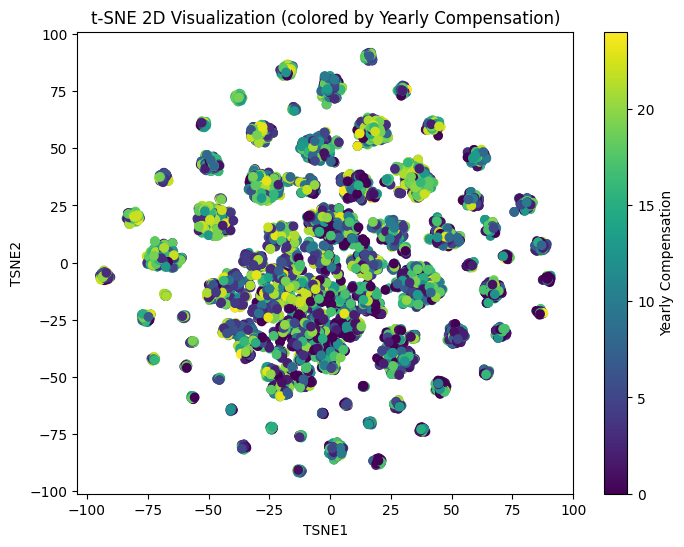

In [9]:
# --- Apply t-SNE (reduce to 2D) ---
tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2D
tsne_results = tsne.fit_transform(scaled_features)

# --- Create DataFrame for t-SNE Results ---
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

# --- Choose the target column as label for coloring ---
c = feature_matrix['yearly_compensation']  # The target column for coloring

# --- Visualize t-SNE Results ---
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=c, cmap='viridis', label='Yearly Compensation')
plt.title('t-SNE 2D Visualization (colored by Yearly Compensation)')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(label='Yearly Compensation')
plt.show()

### UMAP

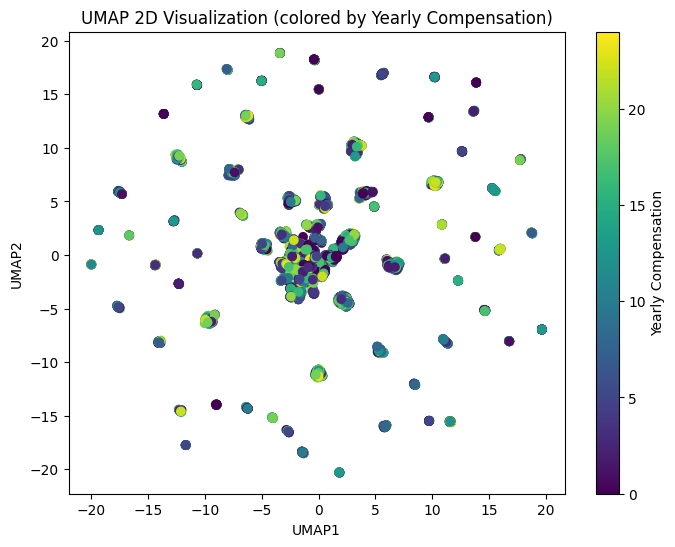

In [10]:
# --- Apply UMAP (reduce to 2D) ---
umap_model = umap.UMAP(n_components=2)
umap_results = umap_model.fit_transform(scaled_features)

# --- Create DataFrame for UMAP Results ---
umap_df = pd.DataFrame(data=umap_results, columns=['UMAP1', 'UMAP2'])

# --- Choose the target column as label for coloring ---
c = feature_matrix['yearly_compensation']  # The target column for coloring

# --- Visualize UMAP Results ---
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=c, cmap='viridis', label='Yearly Compensation')
plt.title('UMAP 2D Visualization (colored by Yearly Compensation)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Yearly Compensation')
plt.show()

### RFE

In [11]:
# Perform RFE on PCA-transformed features
X = pca_df
y = feature_matrix.loc[:, "yearly_compensation"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the logistic regression model
model = LogisticRegression(max_iter=500)

# Create the RFE model and select the top 50 features
rfe = RFE(model, n_features_to_select=50)
rfe = rfe.fit(X_train, y_train)

# Get the features selected by RFE
selected_features = rfe.support_
selected_features

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False,  True,  True,  True,  True, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True])

In [12]:
# Evaluate the model on the test set with the selected features
X_train_rfe = X_train.loc[:, selected_features]
X_test_rfe = X_test.loc[:, selected_features]

model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

In [13]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # or 'micro' / 'weighted'
recall = recall_score(y_test, y_pred, average='macro')  # or 'micro' / 'weighted'
f1 = f1_score(y_test, y_pred, average='macro')  # or 'micro' / 'weighted'

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

Accuracy: 0.7461538461538462, Precision: 0.6668844440648425, Recall: 0.6504835118180029, F1-Score: 0.6508706090193833


In [14]:
# Print selected features
pca_columns = pca_df.columns[selected_features]
print("Selected Features by RFE:", pca_columns)

Selected Features by RFE: Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC7', 'PC8', 'PC9', 'PC10', 'PC12',
       'PC13', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22',
       'PC24', 'PC25', 'PC27', 'PC29', 'PC31', 'PC32', 'PC62', 'PC64', 'PC67',
       'PC68', 'PC69', 'PC70', 'PC72', 'PC73', 'PC74', 'PC77', 'PC79', 'PC80',
       'PC81', 'PC82', 'PC83', 'PC84', 'PC86', 'PC87', 'PC88', 'PC90', 'PC91',
       'PC92', 'PC94', 'PC95', 'PC96'],
      dtype='object')


### Mutual Information

In [15]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the PCA-transformed features and target
X = pca_df
y = feature_matrix.loc[:, "yearly_compensation"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Calculate mutual information
mi_scores = mutual_info_regression(X_train, y_train)

In [16]:
# Create a DataFrame for visualization
mi_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

   Feature  Mutual Information
93    PC94            0.789023
90    PC91            0.587105
0      PC1            0.279808
1      PC2            0.185955
49    PC50            0.180199
..     ...                 ...
25    PC26            0.006303
21    PC22            0.004854
84    PC85            0.000000
10    PC11            0.000000
24    PC25            0.000000

[96 rows x 2 columns]


In [17]:
# Select the top 50 features based on mutual information
top_mi_features = mi_df.head(50)['Feature']
print("Selected Features by Mutual Information:", top_mi_features)

Selected Features by Mutual Information: 93    PC94
90    PC91
0      PC1
1      PC2
49    PC50
56    PC57
47    PC48
52    PC53
53    PC54
41    PC42
42    PC43
38    PC39
43    PC44
94    PC95
54    PC55
50    PC51
44    PC45
57    PC58
55    PC56
51    PC52
63    PC64
36    PC37
46    PC47
48    PC49
4      PC5
37    PC38
30    PC31
39    PC40
40    PC41
35    PC36
34    PC35
59    PC60
45    PC46
83    PC84
58    PC59
62    PC63
60    PC61
31    PC32
85    PC86
61    PC62
33    PC34
32    PC33
2      PC3
64    PC65
69    PC70
91    PC92
65    PC66
15    PC16
92    PC93
79    PC80
Name: Feature, dtype: object


In [18]:
# Evaluate the model on the test set with the selected features
X_train_mi = X_train[top_mi_features]
X_test_mi = X_test[top_mi_features]

model = LogisticRegression(max_iter=500)
model.fit(X_train_mi, y_train)
y_pred = model.predict(X_test_mi)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

Accuracy: 0.4739316239316239, Precision: 0.3929095454992887, Recall: 0.375518164673375, F1-Score: 0.36949208524181165


### Lasso Regression

In [19]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the PCA-transformed features and target
X = pca_df
y = feature_matrix.loc[:, "yearly_compensation"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and fit the Lasso model
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, max_iter=10000)

In [20]:
# Get the coefficients
lasso_coefficients = pd.Series(lasso.coef_, index=X_train.columns)
important_features = lasso_coefficients[lasso_coefficients != 0].index
print("Selected Features by Lasso Regression:", important_features)

Selected Features by Lasso Regression: Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28',
       'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37',
       'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46',
       'PC47', 'PC48', 'PC49', 'PC50', 'PC51', 'PC52', 'PC53', 'PC54', 'PC55',
       'PC57', 'PC58', 'PC59', 'PC60', 'PC61', 'PC62', 'PC63', 'PC64', 'PC65',
       'PC66', 'PC67', 'PC68', 'PC69', 'PC70', 'PC71', 'PC72', 'PC73', 'PC74',
       'PC75', 'PC76', 'PC77', 'PC78', 'PC79', 'PC80', 'PC81', 'PC82', 'PC83',
       'PC84', 'PC85', 'PC86', 'PC87', 'PC88', 'PC89', 'PC90', 'PC91', 'PC92',
       'PC93'],
      dtype='object')


In [21]:
# Evaluate the model on the test set with the selected features
X_train_lasso = X_train[important_features]
X_test_lasso = X_test[important_features]

model = LogisticRegression(max_iter=500)
model.fit(X_train_lasso, y_train)
y_pred = model.predict(X_test_lasso)

In [22]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

Accuracy: 0.7341880341880341, Precision: 0.656455350969097, Recall: 0.63773802950724, F1-Score: 0.6401733928855282


### Comparing & Combining Features

In [23]:
# List of selected features from each method
features_rfe = set(pca_columns)
features_mi = set(top_mi_features)
features_lasso = set(important_features)

# Find common features
common_features = features_rfe.intersection(features_mi).intersection(features_lasso)
print("Common Features:", common_features)

Common Features: {'PC3', 'PC16', 'PC91', 'PC86', 'PC62', 'PC80', 'PC84', 'PC70', 'PC5', 'PC92', 'PC32', 'PC2', 'PC64', 'PC31', 'PC1'}


In [24]:
# Find unique features
unique_features_rfe = features_rfe - common_features
unique_features_mi = features_mi - common_features
unique_features_lasso = features_lasso - common_features

In [25]:
print("Unique Features RFE:", unique_features_rfe)

Unique Features RFE: {'PC73', 'PC7', 'PC13', 'PC94', 'PC77', 'PC96', 'PC25', 'PC9', 'PC17', 'PC74', 'PC81', 'PC21', 'PC88', 'PC10', 'PC4', 'PC68', 'PC8', 'PC29', 'PC69', 'PC24', 'PC95', 'PC67', 'PC19', 'PC20', 'PC15', 'PC90', 'PC72', 'PC27', 'PC87', 'PC12', 'PC79', 'PC82', 'PC83', 'PC22', 'PC18'}


In [26]:
print("Unique Features Mutual Information:", unique_features_mi)

Unique Features Mutual Information: {'PC40', 'PC46', 'PC94', 'PC48', 'PC47', 'PC38', 'PC65', 'PC54', 'PC63', 'PC44', 'PC61', 'PC66', 'PC42', 'PC43', 'PC37', 'PC45', 'PC39', 'PC51', 'PC59', 'PC35', 'PC58', 'PC52', 'PC49', 'PC34', 'PC95', 'PC56', 'PC55', 'PC93', 'PC41', 'PC50', 'PC60', 'PC53', 'PC33', 'PC36', 'PC57'}


In [27]:
print("Unique Features Lasso:", unique_features_lasso)

Unique Features Lasso: {'PC13', 'PC65', 'PC76', 'PC17', 'PC66', 'PC28', 'PC26', 'PC37', 'PC21', 'PC39', 'PC23', 'PC59', 'PC68', 'PC35', 'PC34', 'PC85', 'PC49', 'PC69', 'PC30', 'PC6', 'PC67', 'PC89', 'PC93', 'PC75', 'PC15', 'PC90', 'PC50', 'PC60', 'PC33', 'PC83', 'PC18', 'PC22', 'PC11', 'PC40', 'PC73', 'PC7', 'PC46', 'PC38', 'PC47', 'PC77', 'PC48', 'PC54', 'PC63', 'PC25', 'PC9', 'PC44', 'PC61', 'PC42', 'PC43', 'PC74', 'PC81', 'PC45', 'PC88', 'PC10', 'PC51', 'PC4', 'PC8', 'PC29', 'PC58', 'PC52', 'PC24', 'PC78', 'PC19', 'PC55', 'PC14', 'PC20', 'PC41', 'PC72', 'PC71', 'PC27', 'PC87', 'PC12', 'PC79', 'PC53', 'PC82', 'PC36', 'PC57'}


In [28]:
# Create combined feature set
combined_features = list(features_rfe.union(features_mi).union(features_lasso))
print("Combined Feature Set:", combined_features)

Combined Feature Set: ['PC13', 'PC65', 'PC76', 'PC96', 'PC28', 'PC39', 'PC59', 'PC35', 'PC85', 'PC93', 'PC75', 'PC50', 'PC83', 'PC22', 'PC73', 'PC62', 'PC40', 'PC7', 'PC77', 'PC25', 'PC44', 'PC64', 'PC61', 'PC42', 'PC3', 'PC84', 'PC45', 'PC10', 'PC51', 'PC8', 'PC29', 'PC86', 'PC19', 'PC56', 'PC20', 'PC41', 'PC72', 'PC71', 'PC12', 'PC79', 'PC53', 'PC57', 'PC94', 'PC17', 'PC66', 'PC37', 'PC26', 'PC21', 'PC92', 'PC5', 'PC23', 'PC32', 'PC68', 'PC91', 'PC80', 'PC69', 'PC49', 'PC34', 'PC30', 'PC67', 'PC6', 'PC89', 'PC15', 'PC90', 'PC60', 'PC33', 'PC18', 'PC11', 'PC46', 'PC48', 'PC47', 'PC70', 'PC38', 'PC54', 'PC63', 'PC9', 'PC43', 'PC74', 'PC81', 'PC88', 'PC4', 'PC16', 'PC58', 'PC52', 'PC24', 'PC95', 'PC78', 'PC31', 'PC55', 'PC14', 'PC27', 'PC87', 'PC2', 'PC82', 'PC36', 'PC1']


In [29]:
# Train and evaluate model using the combined feature set
X_combined_train = X_train[combined_features]
X_combined_test = X_test[combined_features]

model.fit(X_combined_train, y_train)
y_pred_combined = model.predict(X_combined_test)

In [30]:
# Calculate performance metrics
accuracy_combined = accuracy_score(y_test, y_pred_combined)
precision_combined = precision_score(y_test, y_pred_combined, average='macro')
recall_combined = recall_score(y_test, y_pred_combined, average='macro')
f1_combined = f1_score(y_test, y_pred_combined, average='macro')

print(f"Combined Feature Set - Accuracy: {accuracy_combined}, Precision: {precision_combined}, Recall: {recall_combined}, F1-Score: {f1_combined}")

Combined Feature Set - Accuracy: 0.7329059829059829, Precision: 0.653729700822639, Recall: 0.6359303158922455, F1-Score: 0.6375856454116223


### Feature Selection Comparison Conclusion

**Recursive Feature Elimination (RFE)**

*Performance Metrics:*
- **Accuracy**: 0.7462
- **Precision**: 0.6669
- **Recall**: 0.6505
- **F1-Score**: 0.6509

*Conclusion:*
RFE yields the best overall performance in terms of all metrics. The features selected by RFE are most effective in predicting the yearly compensation, making RFE the preferred choice for feature selection.

--

**Lasso Regression**

*Performance Metrics:*
- **Accuracy**: 0.7342
- **Precision**: 0.6565
- **Recall**: 0.6377
- **F1-Score**: 0.6402

*Conclusion:*
Lasso Regression performs well but slightly worse than RFE. It still achieves good performance and is a solid alternative if RFE is not suitable for some reason (computational constraints).

--

**Mutual Information**

*Performance Metrics:*
- **Accuracy**: 0.4739
- **Precision**: 0.3929
- **Recall**: 0.3755
- **F1-Score**: 0.3695

*Conclusion:*
Mutual Information performs significantly worse than the other methods in terms of all metrics. This suggests that it is not as effective in selecting features that predict the yearly compensation well for this dataset.

--

**Combined Feature Set**

*Performance Metrics:*
- **Accuracy**: 0.7329
- **Precision**: 0.6537
- **Recall**: 0.6359
- **F1-Score**: 0.6376

*Conclusion:*
The combined feature set performs similarly to Lasso Regression but not as well as RFE. This suggests that combining features from different methods doesn't necessarily result in better performance and can introduce some noise.

__

**Final Selection**

*Preferred Method:*
Based on the results, **Recursive Feature Elimination (RFE)** is the best feature selection method for this dataset as it provides the highest accuracy, precision, recall, and F1-Score.


### Export RFE Selected Feature Selection to CSV

In [31]:
# Create a DataFrame with the selected features from RFE
selected_features_df = X_train.loc[:, selected_features]

# Combine with the target variable for completeness (optional)
selected_features_df['yearly_compensation'] = y_train.reset_index(drop=True)

# Export the DataFrame to a CSV file
selected_features_df.to_csv('selected_features_rfe.csv', index=False)

print("CSV file with selected features exported successfully.")

C:\Users\Muqri Qawiem\AppData\Local\Temp\ipykernel_10912\3348643856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df['yearly_compensation'] = y_train.reset_index(drop=True)


CSV file with selected features exported successfully.
